In this notebook I compute the probability of incorrect classification for sequentially learned patterns. The classification is done first for a readout receiving one set of inputs trained with supervised learning, then by a readout unit receiving two sets of inputs: one with fast supervised learning and another with slow reinforcement learning. I'll also compare the theoretical results with simulations. The whole notebook should run in $\sim 30$ minutes.

This code may be reused or adapted, in which case please cite the following paper:

"Remembrance of things practiced: Fast and slow learning in cortical and subcortical circuits,"
James M. Murray and G. Sean Escola (Nature Communications, 2020).

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.special import erf, erfc
from scipy.integrate import quad

def theta(h):
    return 0.5*(1 + np.sign(h))


Given random patterns $x_i^\mu, y_i^\mu \sim \mathcal{N}(0, 1)$ and output $z^\mu = \mathrm{sgn}(\mathbf{w} \cdot \mathbf{x}^\mu + \mathbf{v} \cdot \mathbf{y}^\mu)$, the classifier is trained sequentially on $P$ patterns using the fast supervised learning rule
$$
\Delta \mathbf{w}^\mu = \frac{1}{N} (\hat{z}^\mu - \mathbf{w} \cdot \mathbf{x}^\mu ) \mathbf{x}^\mu
    \Theta (1 - \hat{z}^\mu \mathbf{w} \cdot \mathbf{x}^\mu),
$$
so that, just after learning pattern $\mu$, the weight vector is $\mathbf{w} = \mathbf{w}^\mu + \Delta \mathbf{w}^\mu$. Further below, a second set of input weights is added and trained using a slow Hebbian learning rule:
$$
\Delta \mathbf{v}^\mu = -\frac{\alpha}{N} \mathbf{v}^\mu
    + \frac{\beta n_\mu}{N^2 \bar{n}} \hat{z}^\mu \mathbf{y}^\mu
$$

After learning all $P$ patterns in this way, each pattern is tested, and the probability of incorrect classification is given by
$$
p(z^\nu \neq \hat{z}^\nu) = \langle \Theta(- \hat{z}^\nu [\mathbf{w} \cdot \mathbf{x}^\nu) \rangle
$$
in the case with only the first pathway, or
$$
p(z^\nu \neq \hat{z}^\nu) = \langle \Theta(- \hat{z}^\nu [\mathbf{w} \cdot \mathbf{x}^\nu + \mathbf{v} \cdot \mathbf{y}^\nu]) \rangle
$$
in the case with two pathways, where $\mathbf{w}$ and $\mathbf{v}$ contain all of the weight updates made during learning.

In [6]:
def errors(nx, ny, p, n_reps, alpha=1, beta=1, w0=1.2, 
           reinforce=False, rl_params=(1, 0.1, 100), 
           gradient_descent=False, gd_params=(1, 0.1, 100),
           repeated_pattern=None):
    '''
    Given the number of units in each input population , the number of patterns to be
    learned sequentially, and the number of times to repeat training of each pattern, train a
    single network and return a binary array, where each element is 0 if the corresponding
    pattern was recalled correctly during testing, or 1 if incorrect.
    
    Parameters
    ----------
    nx, ny : The numbers of units in the two input layers (x~supervised learning, y~Hebbian learning).
    
    p : The number of patterns to be trained.
    
    n_reps : An array of length p specifying the number of repetitions when training each pattern.
    
    w0 : The initial magnitude of the weight vector undergoing supervised learning.
    
    alpha : Controls the decay rate of Hebbian weights.
    
    beta : Controls the learning rate for the Hebbian weights.
    
    reinforce : If True, use reinforcement learning rather than supervised learning.
    
    rl_params : parameters (sigma, eta, reps) to use for reinforcement learning (if reinforce=True).
    
    gradient_descent : If True, use reinforcement learning rather than the perceptron learning rule.
    
    gd_params : parameters (sigma, eta, reps) to use for gradient descent learning 
        (if gradient_descent=True).
    
    repeated_pattern : A tuple of integers (dtrain, dtest) specifying a pattern to train twice, where
        dtrain is the number of patterns between the first and second presentation, and dtest is the 
        number of patterns between second presentation and testing. If None, no patterns are repeated.
    
    Returns
    -------
    err : An array of length p, where each element is 0 if the corresponding pattern is
        recalled correctly after training, or 1 if recalled incorrectly.
    '''
    n_bar = np.mean(n_reps)
    v0 = beta/alpha**0.5
    
    # If using reinforcement learning, the learning rate and number of repetitions per pattern:
    (sigmaRL, etaRL, repsRL) = rl_params

    # If using gradient descent learning, the learning rate and number of repetitions per pattern:
    (sigmaGD, etaGD, repsGD) = gd_params
    
    x = np.random.randn(p, nx)
    y = np.random.randn(p, ny)
    z_ = np.random.choice([-1, 1], p)
    if repeated_pattern is not None:
        (dtrain, dtest) = repeated_pattern
        x[-dtrain-dtest,:] = x[-dtest,:]
        y[-dtrain-dtest,:] = y[-dtest,:]
        z_[-dtrain-dtest] = z_[-dtest]
    w = np.zeros((p, nx))
    v = np.zeros((p, ny))
    w[0,:] = w0*np.random.randn(nx)/nx**0.5
    v[0,:] = v0*np.random.randn(ny)/ny**0.5
    dw = np.zeros((p, nx))
    dv = np.zeros((p, ny))
    err = np.zeros(p)
    
    for mu in range(p-1):
        u = np.dot(w[mu,:], x[mu,:]) + np.dot(v[mu,:], y[mu,:])
        if reinforce:  # use reinforcement learning
            rbar = 0
            for ii in range(repsRL):
                xi = sigmaRL*np.random.randn()
                r = z_[mu]*np.sign(u + xi)
                dw[mu,:] += etaRL*(r - rbar)*xi*x[mu,:]/nx
                rbar = 0.9*rbar + 0.1*r
        elif gradient_descent:  # use gradient descent learning
            for ii in range(repsGD):
                xi = sigmaGD*np.random.randn()
                errGD = z_[mu] - np.sign(u + xi)
                dw[mu,:] += etaGD*errGD*x[mu,:]/nx
        else:  # use the perceptron learning rule
            if u*z_[mu] < 1:
                dw[mu,:] = (z_[mu] - u)*x[mu,:]/nx
            
        w[mu+1,:] = w[mu,:] + dw[mu,:]
        dv[mu,:] = -alpha*v[mu,:]/ny + 2**0.5*beta*n_reps[mu]*z_[mu]*y[mu,:]/(n_bar*ny)
        v[mu+1,:] = v[mu,:] + dv[mu,:]

    for nu in range(p-1):
        u = np.dot(w[-1,:], x[nu,:]) + np.dot(v[-1,:], y[nu,:])
        err[nu] = theta(-z_[nu]*u)
                    
    return err, np.linalg.norm(w[-1,:])


def p_inc_sim(n_nets, nx, ny, p, n_reps, alpha=1, beta=1, n_bins=50, 
              repeated_pattern=None):
    '''
    Train and test multiple networks on sequentially repeated patterns, and return the (binned) 
    probability of incorrect classification across patterns.
    
    Returns
    -------
    p_binned : The binned x-axis points. 
    
    p_inc_binned : The probabilities (computed over networks) of incorrect classification across
        patterns.
    '''

    p_inc = np.zeros((n_nets, p))
    w0 = np.zeros(n_nets)
    for ii in range(n_nets):
        p_inc[ii, :], w0[ii] = errors(nx, ny, p, n_reps, alpha=alpha, beta=beta,
                                      repeated_pattern=repeated_pattern)
        
    p_inc_std = np.std(p_inc, axis=0)/n_nets**0.5

    # Bin the data:
    bin_size = p//n_bins
    p_binned = np.arange(p)[::bin_size] + 0.5*bin_size
    p_inc_binned = np.zeros(n_bins)
    p_inc_binned_std = np.zeros(n_bins)
    for ii in range(n_bins):
        p_inc_binned[ii] = np.mean(p_inc[:, ii*bin_size:(ii+1)*bin_size])
        p_inc_binned_std[ii] = np.mean(p_inc_std[ii*bin_size:(ii+1)*bin_size])
    
    if repeated_pattern is not None:
        return p_binned, p_inc_binned, p_inc_binned_std
    else:
        return p_binned, p_inc_binned, np.mean(w0)

# Supervised learning only, without second input pathway

First I'll compute both simulated and theoretical results for the classification error probability in the case where the second input is turned off completely.

In [7]:
# Theoretical result:

w_sol = 1.1
f_sol = 1
g_sol = (1 + w_sol**2)/2
q = 0.5*erfc(-1/(2*w_sol**2)**0.5)

tau_range = np.arange(0.01, 2, 0.01)
def int0(u, gamma, f, g):
    foo = np.exp(-0.5*u**2)*erfc(gamma*u/(2*(1-gamma**2))**0.5)/(8*np.pi)**0.5
    return foo

p_inc0 = np.zeros(0)
for tau in tau_range:
    gamma = np.exp(-q*f_sol*tau)
    bar = quad(int0, (f_sol/g_sol)**0.5, np.inf, args=(gamma, f_sol, g_sol))[0]
    bar += 0.25*erfc(-(0.5*f_sol/g_sol)**0.5)*erfc(gamma*(0.5*f_sol/(g_sol*(1-gamma**2)))**0.5)
    p_inc0 = np.append(p_inc0, bar)


In [8]:
# Simulation with supervised learning:

n_nets = 1
nx, ny = int(2e4), 1  # increase nx to get better statistics
p = int(2*nx)
n_reps = np.ones(p)

p0, p_inc_sim0, _ = p_inc_sim(n_nets, nx, ny, p, n_reps, beta=0)

<IPython.core.display.Javascript object>


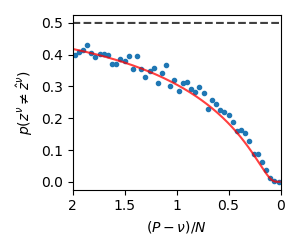

In [9]:
# Plot the results together:

plt.figure(figsize=(3,2.5))
plt.xlim(0,2)

plt.plot(p0/nx, p_inc_sim0, '.')  # Simulated results
plt.plot(np.arange(p)/nx, 0.5*np.ones_like(np.arange(p)), '--k', alpha=0.75)  # Chance performance
plt.plot(tau_range, p_inc0[::-1], 'r', alpha=0.75)  # Theoretical curve

plt.xticks([0, 0.5, 1, 1.5, 2], [2, 1.5, 1, 0.5, 0])
plt.xlabel('$(P-\\nu)/N$')
plt.ylabel('$p(z^\\nu \\neq \hat{z}^\\nu)$')
plt.tight_layout()

# Learning with two pathways

In [7]:
def p_inc_tau(tau_x, tau_y, n_reps_over_n_bar, alpha=1, beta=1, w0=1.2, sigmaP2=None):
    '''
    Compute the theoretical prediction for the probability of incorrect classification
    for a single value of tau_x and tau_y (=(P-nu)/Nx and (P-nu)/Ny, respectively).
    
    Parameters
    ----------
    n_reps_over_n_bar : The number of times to repeat the pattern during Hebbian learning,
        normalized by the average over patterns.
    '''
        
    f = 1
    g = 0.5*(1 + w0**2) + 0.5*beta**2/alpha
    q = 0.5*erfc(-(0.5*f/g)**0.5)

    def integral1(r, gamma, rho, sigmaP2):
        d1 = (1-gamma**2)*g + sigmaP2 + (rho-gamma)**2*beta**2/alpha
        s1 = -1 - d1**-0.5 * r*(rho-gamma)*beta**2/alpha
        s1 *= (g + beta**2/alpha - (rho-gamma)**2/d1*beta**4/alpha**2)**-0.5
        
        return 1/(8*np.pi)**0.5 * np.exp(-0.5*r**2)*erfc(s1/2**0.5)

    def integral2(r, gamma, rho, sigmaP2):
        d2 = g + sigmaP2 + rho**2*beta**2/alpha
        s2 = 1 + r*(gamma*g + rho*beta**2/alpha)/d2**0.5
        s2 *= (g + beta**2/alpha - (gamma*g + rho*beta**2/alpha)**2/d2)**-0.5
        
        return 1/(8*np.pi)**0.5 * np.exp(-0.5*r**2)*erfc(s2/2**0.5)

    gamma = np.exp(-q*f*tau_x)
    rho = np.exp(-alpha*tau_y)
    if sigmaP2 is None:
        sigmaP2 = beta**2*(1-rho**2)/alpha

    d1 = (1-gamma**2)*g + sigmaP2 + (rho-gamma)**2*beta**2/alpha
    r1 = (gamma + 2**0.5*beta*rho*n_reps_over_n_bar)/d1**0.5
    int1 = quad(integral1, r1, np.inf, args=(gamma, rho, sigmaP2))[0]

    d2 = g + sigmaP2 + rho**2*beta**2/alpha
    r2 = (2**0.5 * rho*beta*n_reps_over_n_bar)/d2**0.5
    int2 = quad(integral2, r2, np.inf, args=(gamma, rho, sigmaP2))[0]

    p_incorrect = int1 + int2

    return p_incorrect

In [8]:
def p_inc(n_reps, alpha=1, beta=1, w0=1.2, nx=1000, ny=1000):
    '''
    Compute the theoretical curve for the probability of incorrect classification.
    
    Parameters
    ----------
    n_reps : An array with length equal to the number of patterns giving the number of
        times to repeat each pattern during Hebbian learning, starting from the last 
        pattern learned.
    '''
    
    p = len(n_reps)
    n_bar = np.mean(n_reps)
    n_reps_is_const = (n_bar == np.max(n_reps))
    sigmaP2 = 0
    
    p_incorrect = np.zeros(p)
    #for ii, tau_y in enumerate(tau_range_y):
    for ii in range(p):
        tau_x, tau_y = ii/nx, ii/ny
        #if n_reps_is_const:
        if True:
            sigmaP2 = None
        else:
            sigmaP2 = (1-2*alpha/ny)*sigmaP2 + 2*beta**2*n_reps[ii]**2/(ny*n_bar**2)
        
        p_incorrect[ii] = p_inc_tau(tau_x, tau_y, n_reps[ii]/n_bar, alpha=alpha, 
                                    beta=beta, w0=w0, sigmaP2=sigmaP2)

    return p_incorrect

Below, I'll select a few patterns to repeat many times while presenting all other patterns only once.

<IPython.core.display.Javascript object>


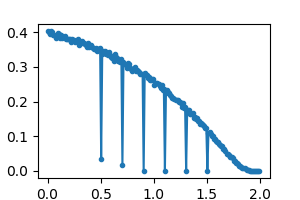

In [9]:
# Simulation (not all of the patterns are shown in this plot due to binning):

n_nets = 1000
nx, ny = 1000, 1000
p = int(2*nx)
n_reps = np.ones(p)
n_reps[[500, 700, 900, 1100, 1300, 1500]] = 10*np.ones(6)

p_vals, p_inc_sim_overtrained, _ = p_inc_sim(n_nets, nx, ny, p, n_reps, alpha=1, beta=1, n_bins=p)

p_ = np.copy(p_inc_sim_overtrained)

# Remove the overtrained patterns:
for ii in [500, 700, 900, 1100, 1300, 1500]:
    p_[ii] = 0.5*(p_[ii-1] + p_[ii+1])

# Bin the data:
n_bins = 200
bin_size = p//n_bins
p_bins = np.arange(p)[::bin_size] + 0.5*bin_size
p_bins *= 1/nx
p_binned = np.zeros(n_bins)
for ii in range(n_bins):
    p_binned[ii] = np.mean(p_[ii*bin_size:(ii+1)*bin_size])

# Put back the overtrained patterns:
for ii in [500, 700, 900, 1100, 1300, 1500]:
    p_binned[int(ii*n_bins/p)] = p_inc_sim_overtrained[ii]
        
plt.figure(figsize=(3, 2))
plt.plot(p_bins, p_binned, '.-')

In [10]:
# Compute a theoretical curve.

# These numbers just determine the number of points on the curve; only the ratio p/ny is meaningful:
p = 2000
ny = 1000
n_reps = np.ones(p)
#n_reps[[500, 1000, 1500]] = 10*np.ones(3)
n_reps[[500, 700, 900, 1100, 1300, 1500]] = 10*np.ones(6)

p_inc_overtrained = p_inc(n_reps, alpha=1, beta=1, w0=1.71, ny=ny)


# As a control, also compute a forgetting curve with the same beta and with no extra repetitions:
n_reps_ctrl = np.ones(p)
p_inc_ctrl = p_inc(n_reps_ctrl, alpha=1, beta=1, w0=1.71, ny=ny)


/Users/murray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
/Users/murray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/Users/murray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/murray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/murray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/murray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


<IPython.core.display.Javascript object>


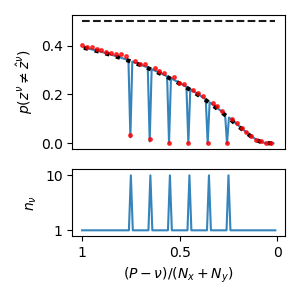

In [11]:
# Plot the results together.

# Use gridspec to create subplots of unequal size:
from matplotlib import gridspec
fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(2,1, height_ratios=[2, 1]) 

ax0 = plt.subplot(gs[0])
ax0.plot(np.arange(20,len(p_inc_overtrained)+20)[::20]*p//ny/len(p_inc_overtrained), 
         p_inc_overtrained[::20][::-1], alpha=0.9)  # Theory

ax0.plot(np.arange(20,len(p_inc_ctrl)+20)[::20]*p//ny/len(p_inc_ctrl), 
         p_inc_ctrl[::20][::-1], ':k', lw=3, alpha=1)  # Theory (control without overtraining)

ax0.plot(np.arange(n_bins)[::5]*p/(ny*n_bins), 
         p_binned[::5], '.r', ms=5, alpha=0.75)  # Simulation

ax0.plot(np.arange(p//ny+1), 0.5*np.ones(p//ny+1), '--k', alpha=0.9)  # Chance performance
plt.ylabel('$p(z^\\nu \\neq \hat{z}^\\nu)$')
plt.xticks([])

ax1 = plt.subplot(gs[1])
ax1.plot(np.arange(len(p_inc_overtrained))[::20]*p//ny/len(p_inc_overtrained), n_reps[::20], alpha=0.9)
plt.ylim(0, 11)
plt.xticks([0, 1, 2], [1, 0.5, 0])
plt.yticks([1, 10])
plt.xlabel('$(P-\\nu)/(N_x+N_y)$')
plt.ylabel('$n_\\nu$')

plt.tight_layout()